### COS 495 PSET 5: ConvNets at Scale
Author: Ari Seff

In [1]:
# automatically reload edited modules
%load_ext autoreload
%autoreload 2

In [2]:
import os
import tarfile
import random
from six.moves import urllib
import tensorflow as tf
import numpy as np
from copy import deepcopy

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython import display

#### Download the CIFAR-10 data if necesssary (163 M)

In [4]:
# adapted from nfmcclure's "tensorflow_cookbook"

cifar10_url = 'http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

# Check if file exists, otherwise download it
data_file = os.path.join('cifar-10-python.tar.gz')
if os.path.isfile(data_file):
    pass
else:
    # Download file
    def progress(block_num, block_size, total_size):
        progress_info = [cifar10_url, float(block_num * block_size) / float(total_size) * 100.0]
        print('\r Downloading {} - {:.2f}%'.format(*progress_info))
        display.clear_output(wait=True)
    filepath, _ = urllib.request.urlretrieve(cifar10_url, data_file, progress)
    # Extract file
    tarfile.open(filepath, 'r:gz').extractall('.')

#### Prepare CIFAR-10 data

In [5]:
import prepare_cifar10
cifar10 = prepare_cifar10.read_data_sets(reshape=False)
categories = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

#### View some images and labels

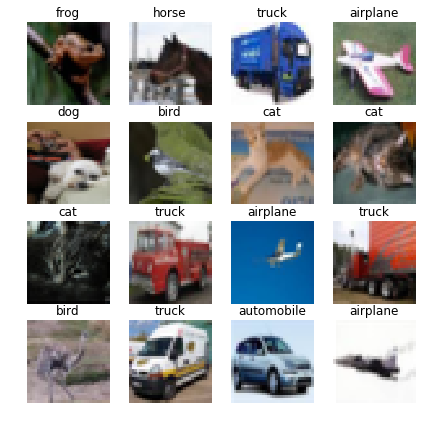

In [6]:
for i in range(16):
    plt.subplot(4,4,i+1)
    images = cifar10.train.images[i]
    plt.imshow(images, interpolation='nearest')
    label = np.argmax(cifar10.train.labels[i])
    plt.title(categories[label])
    plt.axis('off')
plt.gcf().set_size_inches(7,7)

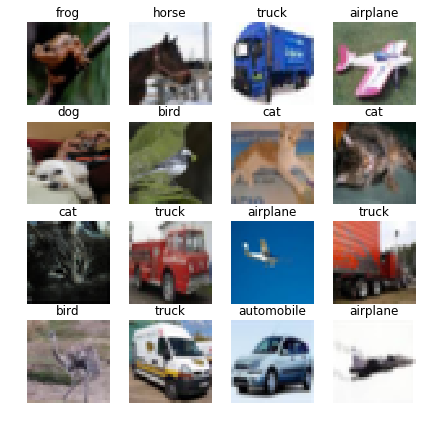

In [7]:
images = cifar10.train.images
for i in range(16):
    plt.subplot(4,4,i+1)
    images[i] = images[i,:,::-1]
    plt.imshow(images[i], interpolation='nearest')
    label = np.argmax(cifar10.train.labels[i])
    plt.title(categories[label])
    plt.axis('off')
plt.gcf().set_size_inches(7,7)

#### Set input/output and training parameters

In [8]:
# Parameters
learning_rate = 0.001
training_iters = 2000
batch_size = 128
val_batch_size = 512
display_step = 20

# Network Parameters
input_shape = [32, 32, 3] # CIFAR=10 data input
n_classes = 10 # CIFAR-10 total classes
dropout = 1.0 # probability to keep units (1.0 indicates no dropout)

# tf Graph input
x = tf.placeholder(tf.float32, input_shape.insert(0, None))
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) # dropout keep probability

#### Define ConvNet wrapper functions

In [9]:
# Create some wrappers for simplicity
def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='SAME')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='SAME')

#### Define architecture

In [10]:
# Create model (adapted from aymericdamien's "TensorFlow-Examples")
def convnet(x, weights, biases, dropout):
    # Reshape input picture
    x = tf.reshape(x, shape=[-1, 32, 32, 3])

    # Convolution Layer
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])
    # Max Pooling (down-sampling)
    conv1 = maxpool2d(conv1, k=2)

    # Convolution Layer
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])
    
    # Convolution Layer
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'])
    # Max Pooling (down-sampling)
    conv3 = maxpool2d(conv3, k=2)

    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc1 = tf.reshape(conv3, [-1, weights['wd1'].get_shape().as_list()[0]])
    fc1 = tf.add(tf.matmul(fc1, weights['wd1']), biases['bd1'])
    fc1 = tf.nn.relu(fc1)
    # Apply Dropout
    fc1 = tf.nn.dropout(fc1, dropout)
    
    # Fully connected layer
    # Reshape conv3 output to fit fully connected layer input
    fc2 = tf.add(tf.matmul(fc1, weights['wd2']), biases['bd2'])
    fc2 = tf.nn.relu(fc2)
    # Apply Dropout
    fc2 = tf.nn.dropout(fc2, dropout)
    
    # Output, class prediction
    out = tf.add(tf.matmul(fc2, weights['out']), biases['out'])
    return out

#### Initialize network weights and set loss function

In [11]:
# Store layers weight & bias
weights = {
    # 3x3 conv, 3 inputs, 32 outputs
    'wc1': tf.Variable(tf.random_normal([3, 3, 3, 32], stddev=0.05)),
    # 3x3 conv, 32 inputs, 64 outputs
    'wc2': tf.Variable(tf.random_normal([3, 3, 32, 64], stddev=0.05)),
    # 3x3 conv, 64 inputs, 64 outputs
    'wc3': tf.Variable(tf.random_normal([3, 3, 64, 64], stddev=0.05)),
    # fully connected, 8*8*64 inputs, 512 outputs
    'wd1': tf.Variable(tf.random_normal([8*8*64, 512], stddev=0.05)),
    # fully connected, 512 inputs, 256 outputs
    'wd2': tf.Variable(tf.random_normal([512, 256], stddev=0.05)),
    # fully connected, 512 inputs, 10 outputs
    'out': tf.Variable(tf.random_normal([256, n_classes], stddev=0.05))
}

biases = {
    'bc1': tf.Variable(tf.zeros([32])),
    'bc2': tf.Variable(tf.zeros([64])),
    'bc3': tf.Variable(tf.zeros([64])),
    'bd1': tf.Variable(tf.zeros([512])),
    'bd2': tf.Variable(tf.zeros([256])),
    'out': tf.Variable(tf.zeros([n_classes]))
}

# Construct model
pred = convnet(x, weights, biases, keep_prob)

# Define loss and optimizer
soft = tf.nn.softmax(pred) # for interpretation only
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# Initializing the variables
init = tf.global_variables_initializer()

#### Begin training

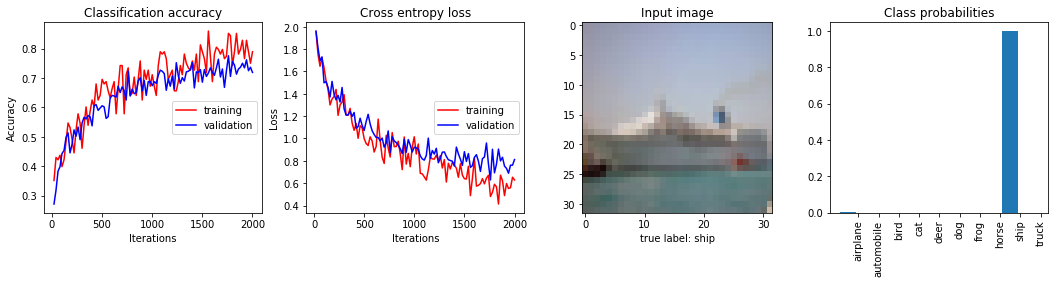

In [12]:
# accuracy/loss plotting helper function
def plot_learning(plot_handles, ylabel):
    plt.legend(handles=plot_handles, loc="center right")
    plt.xlabel("Iterations")
    plt.ylabel(ylabel)

# launch the graph
sess = tf.InteractiveSession()
sess.run(init)
step = 1

# initialize accuracy/loss arrays
train_acc = np.zeros(training_iters/display_step)
train_loss = np.zeros(training_iters/display_step)
val_acc = np.zeros(training_iters/display_step)
val_loss = np.zeros(training_iters/display_step)

# keep training until reach max iterations
while step <= training_iters:
    batch_x, batch_y = cifar10.train.next_batch(batch_size)
    
    # randomly flip batch_x
    for i in range(0, batch_size): 
        ## flip if 50% of the time 
        if random.random() > 0.5: 
            # your app does this 
            batch_x[i] = batch_x[i,:,::-1]
            
    
    # run optimization op (backprop)
    
    sess.run(optimizer, feed_dict={x: batch_x, y: batch_y,
                                   keep_prob: dropout})
    if step % display_step == 0:
        plt.gcf().clear()
        
        # calculate batch loss and accuracy
        train_loss[step/display_step-1], train_acc[step/display_step-1] = sess.run([cost, accuracy], feed_dict={x: batch_x,
                                                          y: batch_y,
                                                          keep_prob: 1.})
        val_batch_x, val_batch_y = cifar10.validation.next_batch(val_batch_size)
        val_loss[step/display_step-1], val_acc[step/display_step-1], this_soft, this_y = sess.run([cost, accuracy, soft, y], feed_dict={x: val_batch_x,
                                                          y: val_batch_y,
                                                          keep_prob: 1.})
        plt.subplot(1,4,1)
        train_plot, = plt.plot(range(display_step,step+1,display_step), train_acc[:step/display_step], 'r', label="training")
        val_plot, = plt.plot(range(display_step,step+1,display_step), val_acc[:step/display_step], 'b', label="validation")
        plot_learning([train_plot, val_plot], "Accuracy")
        plt.title("Classification accuracy")
        
        plt.subplot(1,4,2)
        train_plot, = plt.plot(range(display_step,step+1,display_step), train_loss[:step/display_step], 'r', label="training")
        val_plot, = plt.plot(range(display_step,step+1,display_step), val_loss[:step/display_step], 'b', label="validation")
        plot_learning([train_plot, val_plot], "Loss")
        plt.title("Cross entropy loss")
        
        plt.subplot(1,4,3)
        plt.imshow(val_batch_x[0], interpolation='nearest')
        plt.title("Input image")
        plt.xlabel("true label: " + categories[np.argmax(this_y[0])])
        
        plt.subplot(1,4,4)
        plt.bar(np.arange(0,len(this_soft[0]),1), this_soft[0])
        plt.title("Class probabilities")
        plt.xticks(np.arange(0.5,len(categories),1), categories, rotation="vertical")
        
        plt.gcf().set_size_inches(18, 3.5)
        display.display(plt.gcf())
        wt1 = sess.run(weights['wc1'])
        display.clear_output(wait=True)
    step += 1

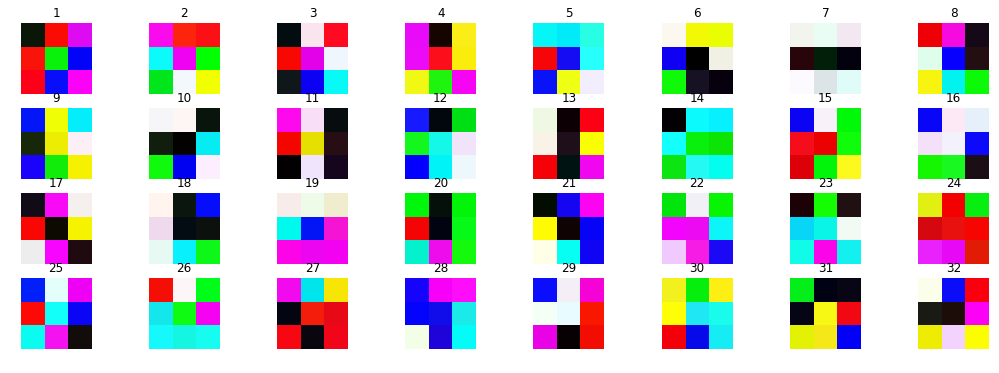

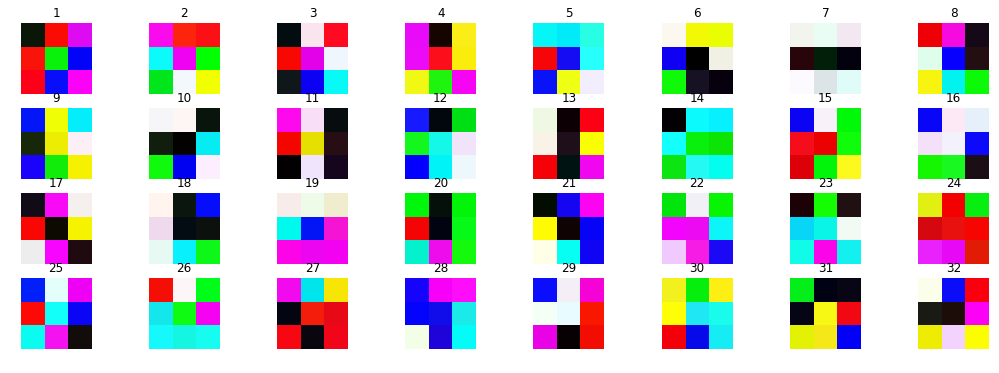

In [13]:
plt.gcf().clear()
wt1 = sess.run(weights['wc1'])
for i in range(32):
    plt.subplot(4,8,i+1)
    plt.imshow(wt1[:,:,:,i], interpolation='nearest')
    label = "Hello"
    plt.title(i+1)
    plt.axis('off')
plt.gcf().set_size_inches(18,6)
display.display(plt.gcf())